In [10]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
DIR_SYMBOLS = './symbols_4'
DIR_IMAGES = './img_test'
DIR_TMP = './tmp'
DEFAULT_TEMPLATE_MATCHING_THRESHOLD = 0.8
THR = 160
OFFSET_PIXELS = 2

In [12]:
# Template Class
class Template:
    def __init__(
        self,
        image_path,
        label,
        color,
        matching_threshold=DEFAULT_TEMPLATE_MATCHING_THRESHOLD
    ):
        self.image_path = image_path
        self.label = label
        self.color = color
        self.template = cv2.imread(image_path)
        self.template_height, self.template_width = self.template.shape[:2]
        self.matching_threshold = matching_threshold

In [13]:
# Read all symbol images
symbols_templates = []
for ifile in os.listdir(DIR_SYMBOLS):
    if ifile.endswith(".png"):
        path = os.path.join(DIR_SYMBOLS, ifile)
        l_, _ = os.path.splitext(ifile)
        label = l_[0]
        t_ = Template(
            image_path=path,
            label=label,
            color=(0,0,255)
        )
        symbols_templates.append(t_)

In [14]:
s_d = {s_.label: s_ for s_ in (symbols_templates)}
s_ = sorted(s_d.keys())

In [15]:
@interact(symbol=s_)
def show_symbol(symbol):
    print(f"Label = {symbol}")
    template = s_d[symbol].template
    print(f"Dim = {template.shape[1]} x {template.shape[0]}")
    plt.imshow(template[:,:,::-1])
    plt.show()


interactive(children=(Dropdown(description='symbol', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'…

In [16]:
# TEST = 'captcha_78.png'
# TEST = 'captcha_83.png'
# TEST = 'captcha_19.png'
TEST = '1w6i.png'
filename, extension = os.path.splitext(TEST)
test_path = os.path.join(DIR_IMAGES, TEST)

In [17]:
img = cv2.imread(test_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_inv = cv2.bitwise_not(gray)
_, img_thr = cv2.threshold(gray_inv, THR, 255, cv2.THRESH_BINARY)
test_file = filename + '_bw' + extension
out_path = os.path.join(DIR_TMP, test_file)
cv2.imwrite(out_path, img_thr)

True

In [18]:
img_thr.shape

(28, 110)

In [19]:
img_g = cv2.cvtColor(img_thr, cv2.COLOR_GRAY2BGR)

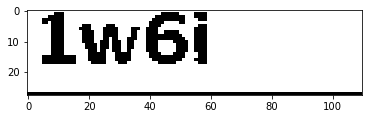

In [20]:
plt.imshow(img_g[:,:,::-1])
plt.show()

In [21]:
img_ = cv2.imread(out_path)

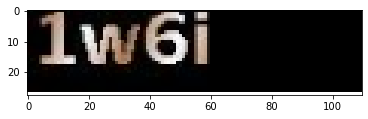

In [22]:
plt.imshow(img[:,:,::-1])
plt.show()

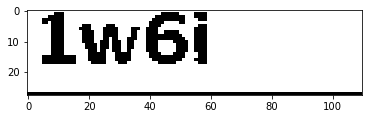

In [23]:
plt.imshow(img_[:,:,::-1])
plt.show()

In [24]:
img_.shape

(28, 110, 3)

In [38]:
detections = []
img_patch = img_
width = img_patch.shape[1]
offset = 0
max_attempts = 20
attempts = 0

while offset < width:
    detections_ = []
    # Search template for all symbols
    for template in symbols_templates:
        try:
            template_matching = cv2.matchTemplate(
                template.template, img_patch, cv2.TM_CCOEFF_NORMED
            )
            match_locations = np.where(template_matching >= template.matching_threshold)
            for (x, y) in zip(match_locations[1], match_locations[0]):
                match = {
                    "TOP_LEFT_X": x,
                    "TOP_LEFT_Y": y,
                    "BOTTOM_RIGHT_X": x + template.template_width,
                    "BOTTOM_RIGHT_Y": y + template.template_height,
                    "MATCH_VALUE": template_matching[y, x],
                    "LABEL": template.label,
                    "COLOR": template.color
                }
                # Append to detections
                detections_.append(match)
        except cv2.error as e:
            pass
            
    # If no detections finish
    if len(detections_) > 0:
        # Find the first ones
        d_ = sorted(detections_, key=lambda obj: obj['TOP_LEFT_X'], reverse=False)
        # print(d_)
        fst_ = []
        fst_.append(d_[0])
        xmin = d_[0]['TOP_LEFT_X']
        xmax = (xmin + d_[0]['BOTTOM_RIGHT_X'])//2
        filtered = list(filter(lambda obj: obj['TOP_LEFT_X'] <= xmax, d_[1:]))
        fst_ = fst_ + filtered
        # Sort and select the one with highest MATCH_VALUE
        fst_sorted = sorted(fst_, key=lambda obj: obj['MATCH_VALUE'], reverse=True)
        detected = fst_sorted[0]
        # Reduce the image
        old_x = detected['BOTTOM_RIGHT_X']
        img_patch = img_patch[:,old_x+1-OFFSET_PIXELS:,:]
        # Update
        detected['TOP_LEFT_X'] = detected['TOP_LEFT_X'] + offset
        detected['BOTTOM_RIGHT_X'] = detected['BOTTOM_RIGHT_X'] + offset
        # Update offset
        offset += old_x + 1 - OFFSET_PIXELS
        detections.append(detected)
    else:
        break
        
    if attempts > max_attempts:
        break
    attempts += 1

In [39]:
detections

[{'TOP_LEFT_X': 4,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 17,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 1.0,
  'LABEL': '1',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 17,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 38,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.8882846,
  'LABEL': 'w',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 38,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 55,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 1.0,
  'LABEL': '6',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 54,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 84,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.93781894,
  'LABEL': 'i',
  'COLOR': (0, 0, 255)}]

In [40]:
# Draw detection box
images_with_detections = []
for detection in detections:
    i_ = img_.copy()
    cv2.rectangle(
        i_,
        (detection["TOP_LEFT_X"], detection["TOP_LEFT_Y"]),
        (detection["BOTTOM_RIGHT_X"], detection["BOTTOM_RIGHT_Y"]),
        detection["COLOR"],
        1
    )
    images_with_detections.append(i_)

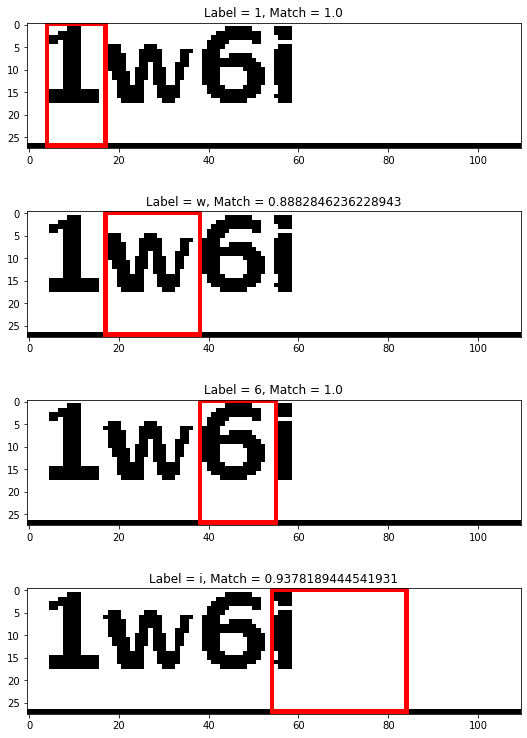

In [41]:
# Plot detections
fig, axs = plt.subplots(nrows=len(images_with_detections), ncols=1, figsize=(16,12))
for idx, ax in enumerate(axs):
    ax.imshow(images_with_detections[idx][:,:,::-1])
    ax.set_title(f"Label = {detections[idx]['LABEL']}, Match = {detections[idx]['MATCH_VALUE']}")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

In [42]:
d_ = [d['LABEL'] for d in detections]
print("".join(d_))

1w6i
